In [1]:
#To explore census data we need to access the data.
#We will start by accessing the data available by the Census API (Population per single year age per year from 2000-2019 [and possibly since 1990])

In [2]:
#First we requested Census API our key here: https://api.census.gov/data/key_signup.html
#And we saved our key in a text file on our computer which we now read from file:
f = open("../../../keys/us_census_api.txt", "r")
my_key = f.read()
f.close()

In [3]:
import requests
import numpy as np
import pandas as pd
import calendar


In [4]:
decade = '00'
print(1900+int(decade),1910+int(decade)-1) #test string operations

1900 1909


In [8]:
#import 1900-1979 data from excel spreadsheets
#Source: https://www.census.gov/data/tables/time-series/demo/popest/pre-1980-national.html
decades_arr = np.array(list(range(1,8)))*10 #create array of numerical decades betwen 09 and 79.
decades_list = ['00']+list(decades_arr.astype(str)) #covert array of numerical decades to strings and 
                                                    #prepend '00'

#Procedure to clean and prep input tables into standardized panda arrays
def prep_year_df(df_now, year, month = 7):
    #remove unnecessary rows
    df_now = df_now.dropna()
    #remove unnecessary columns
    df_now = df_now[['Unnamed: 0','Unnamed: 1']]
    #rename columns
    df_now = df_now.rename(columns={'Unnamed: 0':"AGE",'Unnamed: 1':"TOT_POP"})
    #Change special age values and extend list to AGE = 100
    df_now.at[0,'AGE'] = '999' #From "All ages"
    if year < 1940:
        df_now.at[77,'AGE'] = '75' #From "75+"
        df = pd.DataFrame({'AGE': [str(x) for x in list(range(76,101))],
                           'TOT_POP': [0]*len(list(range(76,101)))})
        #df_now = df_now.append(df,ignore_index=True)
        df_now = pd.concat([df_now,df],axis=0, join='outer',ignore_index=True)
    else:
        df_now.at[87,'AGE'] = '85' #From "85+"
        df = pd.DataFrame({'AGE': [str(x) for x in list(range(86,101))],
                           'TOT_POP': [0]*len(list(range(86,101)))})
        #df_now = df_now.append(df,ignore_index=True)
        df_now = pd.concat([df_now,df],axis=0, join='outer',ignore_index=True)

    #retype columns
    for key in ['AGE','TOT_POP']:
        df_now[key] = pd.to_numeric(df_now[key])
    #make sure AGE runs to 100.

    #add year, month, and day columns
    df_now['YEAR'] = year
    df_now['MONTH'] = month
    df_now['DAY'] = 1
    #convert to and add datetime column
    df_now['DATE'] = pd.to_datetime(df_now[['YEAR', 'MONTH','DAY']])
    #remove year, month, and day columns
    df_now = df_now[['AGE','TOT_POP','DATE']]
    #index properly
    #df_now = df_now.set_index(['YEAR','MONTH','AGE'])
    df_now = df_now.set_index(['DATE','AGE'])
    df_now = df_now.sort_index() #so index handling is more efficient
    df_now = df_now.unstack()
    return df_now
    
    
for decade in decades_list:
    if decade in ['60','70']:
        header = 5
    else:
        header = 6
    dict_one_decade = pd.read_excel('../data/raw/resident-and-military/1900-1970/pe-11-19'+decade+'s.xls', 
                             header=header,sheet_name=list(range(0,10)))

    years = list(range(1900+int(decade),1910+int(decade)))
    for key in dict_one_decade.keys():
        df_loop = prep_year_df(dict_one_decade[key],years[key])
        if (decade == '00') & (key == 0):
            df_all = df_loop.copy()
        else:
            #df_all = df_all.append(df_loop)
            df_all = pd.concat([df_all,df_loop],axis=0, join='outer')

        

In [9]:
df_all['TOT_POP',76]

DATE
1900-07-01          0.0
1901-07-01          0.0
1902-07-01          0.0
1903-07-01          0.0
1904-07-01          0.0
                ...    
1975-07-01     896927.0
1976-07-01     985573.0
1977-07-01     973432.0
1978-07-01     911426.0
1979-07-01    1001631.0
Name: (TOT_POP, 76), Length: 80, dtype: float64

In [10]:
#For testing
#df_now = dict_one_decade[0]
#year = 1979
#month = 7

In [11]:
#1980-1989

#Data source: https://www.census.gov/data/datasets/time-series/demo/popest/1980s-national.html

#We need a list of tuples giving the extent of each column. nice.
#Getting colspecs from: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/1980-1990/nat-detail-layout.txt
#I put free space 12 on previous column and made some other column adjustments
colspecs = [(1,2),(3,4),(5,6),(7,11),(12,21),(22,31),(32,42),(43,52),(53,62),(63,72),(73,82),(83,92),(93,102),(103,112),(113,122),(123,132),(133,142),(143,152),(153,162),(163,172),(173,182),(183,192),(193,202),(203,212),(213,222)]
#shifting colspecs to actually work
for iii,ii in enumerate(colspecs):
    ii_list = list(ii)
    ii_list[0]-=1
    colspecs[iii] = tuple(ii_list)

start_year_arr = np.arange(80,90,1).astype(str)
end_year_arr = np.arange(81,91,1).astype(str)
for sy, ey in zip(start_year_arr, end_year_arr):
    df_80s = pd.read_fwf('../data/raw/resident-and-military/'+
                         '1980-1989/E'+sy+ey+'PQI.TXT',colspecs = colspecs,
                         header=None)
    #drop last row
    df_80s.drop(df_80s.tail(1).index,inplace=True)
    #Rename columns and update years
    df_80s = df_80s.rename(columns={1:'MONTH',2:"YEAR",3:"AGE",4:"TOT_POP"})
    df_80s['YEAR']+=1900
    #Create date columns
    df_80s['DAY'] = 1
    df_80s['DATE'] = pd.to_datetime(df_80s[['YEAR', 'MONTH','DAY']])
    #remove year, month, and day columns
    df_80s = df_80s[['AGE','TOT_POP','DATE']]
    #retype columns
    #for key in ['TOT_POP', 'AGE']:
    #    df_80s.loc[:,key] = pd.to_numeric(df_80s[key])
    #index properly
    #df_now = df_now.set_index(['YEAR','MONTH','AGE'])
    df_80s = df_80s.set_index(['DATE','AGE'])
    df_80s = df_80s.sort_index() #so index handling is more efficient
    df_80s = df_80s.unstack()

    #df_all = df_all.append(df_80s)
    df_all = pd.concat([df_all,df_80s],axis=0, join='outer')



In [12]:
df_all.index[81]

Timestamp('1980-07-01 00:00:00')

In [13]:
df_80s.dtypes

         AGE  
TOT_POP  0.0      float64
         1.0      float64
         2.0      float64
         3.0      float64
         4.0      float64
                   ...   
         97.0     float64
         98.0     float64
         99.0     float64
         100.0    float64
         999.0    float64
Length: 102, dtype: object

In [14]:
#1990-2000
#Every month from Apr 1990 to Apr 2000 #July is the standard in other years
response = requests.get("https://api.census.gov/data/1990/pep/"+
                        "int_natresafo?get=AGE,TOT_POP,YEAR,MONTH&key="+my_key)
#AGE, POP, YEAR, MONTH

In [15]:
print(response)

<Response [200]>


In [16]:
print(np.array(response.json()).shape)
#print(response.json())

(12343, 4)


In [17]:
arr_90s = np.array(response.json())

In [18]:
arr_90s[0:1][0]

array(['AGE', 'TOT_POP', 'YEAR', 'MONTH'], dtype='<U9')

In [19]:
#put array in dataframe
df_90s = pd.DataFrame(data=arr_90s[1:], columns=arr_90s[0:1][0])
#retype columns
for key in ['AGE','TOT_POP','YEAR']:
    df_90s[key] = pd.to_numeric(df_90s[key])
#convert month to month abbr
df_90s['MONTH'] = df_90s['MONTH'].apply(lambda x: 
    np.where(np.array(list(calendar.month_name))==x)[0][0])
#add day column
df_90s['DAY'] = 1

#convert to and add datetime column
df_90s['DATE'] = pd.to_datetime(df_90s[['YEAR', 'MONTH','DAY']])
#remove year, month, and day columns
df_90s = df_90s[['AGE','TOT_POP','DATE']]
#index properly
#df_now = df_now.set_index(['YEAR','MONTH','AGE'])
df_90s = df_90s.set_index(['DATE','AGE'])
df_90s=df_90s.sort_index() #so index handling is more efficient
df_90s=df_90s.unstack()

#df_all = df_all.append(df_90s)
df_all = pd.concat([df_all,df_90s],axis=0, join='outer')


In [20]:
df_90s

TOT_POP                                                        \
AGE             0        1        2        3        4        5        6     
DATE                                                                        
1990-04-01  3947313  3769554  3702679  3641649  3703886  3635463  3580577   
1990-05-01  3964548  3778514  3702336  3644592  3704656  3651932  3572301   
1990-06-01  3980748  3788234  3706596  3647611  3701516  3670703  3568235   
1990-07-01  3986488  3798100  3712522  3660016  3699321  3681034  3563046   
1990-08-01  4000735  3807679  3719875  3662484  3699179  3690818  3570046   
...             ...      ...      ...      ...      ...      ...      ...   
1999-12-01  3794814  3812075  3766371  3832208  3935384  3987445  4030111   
2000-01-01  3803453  3816646  3773178  3840163  3924534  3984021  4024543   
2000-02-01  3805438  3817807  3775224  3843370  3923748  3980427  4023277   
2000-03-01  3802478  3818827  3782065  3833380  3931003  3974957  4020758   
2000-04-01  3805648  3820582  3790446  3832799  3926323  3965103  4019705   

                                       ...                                 \
AGE             7        8        9    ...     92      93      94     95    
DATE                                   ...                                  
1990-04-01  3647972  3473320  3704888  ...  142126  115852   91968  67864   
1990-05-01  3650545  3483045  3692698  ...  142455  116031   92320  68348   
1990-06-01  3647710  3496800  3684170  ...  142832  116241   92686  68833   
1990-07-01  3644060  3510580  3678026  ...  143188  116435   93022  69255   
1990-08-01  3634416  3518620  3670172  ...  143775  116733   93354  69877   
...             ...      ...      ...  ...     ...     ...     ...    ...   
1999-12-01  4136509  4165092  4264579  ...  215860  168865  133456  97045   
2000-01-01  4134443  4171709  4264360  ...  216653  168821  132885  97375   
2000-02-01  4124282  4172744  4268688  ...  216856  168802  132114  97652   
2000-03-01  4114111  4181329  4269252  ...  217702  168813  131461  97669   
2000-04-01  4118147  4179230  4267320  ...  218217  169066  130958  98095   

                                                          
AGE           96     97     98     99     100        999  
DATE                                                      
1990-04-01  50322  37567  25910  21364  35818  249305856  
1990-05-01  50496  37707  25998  21234  36046  249565477  
1990-06-01  50676  37850  26087  21111  36272  249848721  
1990-07-01  50835  37965  26153  20989  36486  250131894  
1990-08-01  51114  38089  26462  20689  36901  250438798  
...           ...    ...    ...    ...    ...        ...  
1999-12-01  72342  51919  37403  26710  49852  280716415  
2000-01-01  72361  52195  36892  26984  49940  280975803  
2000-02-01  72358  52402  36549  27045  50031  281189932  
2000-03-01  72574  52570  36255  27075  50159  281408939  
2000-04-01  72680  52844  36003  27162  50454  281674017  

[121 rows x 102 columns]

In [21]:
#2000-2010
#Grabbing all estiamtes.
#DATE_ = 1 : Apr 1, 2000
#DATE_ = 2 : Jul 1, 2000
#DATE_ = 3 : Jul 1, 2001
#...
#DATE_ = 11 : Jul 1, 2009
#DATE_ = 12 : Apr 1, 2010

#All possible variable values listed here: 
#https://www.census.gov/data/developers/data-sets/popest-popproj/popest/popest-vars.2000-2010_Intercensals.html
for date_loop in range(1,13):
    response = requests.get("https://api.census.gov/data/2000/pep/"+
                            "int_charage?get=AGE,POP,DATE_DESC&for=us:1"+
                            "&DATE_="+str(date_loop)+"&key="+my_key)
    #Columns in output:
    #AGE
    #POP
    #DATE_DESC (contains calendar date)
    #DATE_ (code for date)
    #us (value is 1 for national)

    arr_2000s = np.array(response.json())
    #put array in dataframe
    df_2000s = pd.DataFrame(data=arr_2000s[1:], columns=arr_2000s[0:1][0])

    #rename POP to TOT_POP
    df_2000s = df_2000s.rename(columns={'POP':"TOT_POP"})
    #pull date from DATE_DESC column (all characters before first space!)
    #remove all characters after first space
    df_2000s['DATE_DESC'] = df_2000s['DATE_DESC'].apply(
        lambda x: x[:x.find(' ')])
    #convert date_str to datetime
    df_2000s['DATE'] = pd.to_datetime(df_2000s['DATE_DESC'])
    #remove "us", DATE_, and DATE_DESC columns
    df_2000s = df_2000s[['AGE','TOT_POP','DATE']]
    #retype columns
    for key in ['AGE','TOT_POP']:
        df_2000s[key] = pd.to_numeric(df_2000s[key])
    #index properly
    df_2000s = df_2000s.set_index(['DATE','AGE'])
    df_2000s = df_2000s.sort_index() #so index handling is more efficient
    df_2000s = df_2000s.unstack()
    
    #df_all = df_all.append(df_2000s)
    df_all = pd.concat([df_all,df_2000s],axis=0, join='outer')

In [22]:
#for testing API call
#print(response)
#print(np.array(response.json()).shape)
#print(response.json())

In [23]:
#2010-2015

#DATE_ = 1 : Apr 1, 2010 (census count) #gives response code 204... so skipping
#DATE_ = 2 : Apr 1, 2010 (estimate)
#DATE_ = 3 : July 1, 2010 (estimate)
#DATE_ = 4 : July 1, 2011 (estimate)
#...
#DATE_ = 7 = 7/1/2014 (estimate)
#DATE_ = 8 = 7/1/2015 (estimate)

#Generate list of datetimes for 2015 API
dates1 = pd.date_range('04-01-2010', periods=1, freq='MS')
dates2 = pd.date_range('07-01-2010', periods=6, freq='AS-JUL')
combined = pd.concat([dates1.to_series(), dates2.to_series()])
dates = pd.DatetimeIndex(combined.values)


for ii, date in enumerate(dates):
    print(date)
    #response = requests.get("https://api.census.gov/data/2013/pep/"+
    #                    "monthlynatchar5?get=POP,RACE5,SEX,AGE,HISP&DATE_="+
    #                        str(ii+2)+"&UNIVERSE=P&key="+my_key)

    response = requests.get("https://api.census.gov/data/2015/pep/"+
                        "charage?get=GEONAME,POP,AGE,DATE_DESC&DATE_="+
                            str(ii+2)+"&for=us:*&key="+my_key)
    #Columns in output:
    #'GEONAME', 'POP', 'AGE', 'DATE_DESC', 'DATE_', 'us'

    #for testing
    print(response.status_code)
    #print(response.json())

    arr_15s = np.array(response.json())

    #put array in dataframe
    df_15s = pd.DataFrame(data=arr_15s[1:], columns=arr_15s[0])

    #retype columns
    for key in ['POP', 'AGE', 'DATE_', 'us']:
        df_15s[key] = pd.to_numeric(df_15s[key])
    #sort by AGE
    df_15s = df_15s.sort_values(by=['AGE'])
    #b/c all RACE, SEX, and HISP values are independent, we can sum over all values per AGE to get POP_TOT
    #df_13s = df_13s.groupby(['AGE']).sum()
    #Rename column 'POP' to "TOT_POP"
    df_15s = df_15s.rename(columns={'POP':"TOT_POP"})
    #remove unnecessary columns
    df_15s = df_15s.reset_index()
    df_15s = df_15s[['TOT_POP','AGE']]
    #Add proper DATE column
    #df_13s['DATE'] = 'Apr 1, 2010'
    df_15s['DATE'] = date
    #Add age 999 column with sum of all ages
    #df_13s = df_13s.append(pd.DataFrame({'AGE':999, 'TOT_POP': df_13s['TOT_POP'].sum(),'DATE':df_13s.loc[0,'DATE']},index=[999]))
    #index properly
    df_15s = df_15s.set_index(['DATE','AGE'])
    df_15s = df_15s.sort_index() #so index handling is more efficient
    df_15s = df_15s.unstack()

    #df_all = df_all.append(df_15s)
    df_all = pd.concat([df_all,df_15s],axis=0, join='outer')

2010-04-01 00:00:00
200
2010-07-01 00:00:00
200
2011-07-01 00:00:00
200
2012-07-01 00:00:00
200
2013-07-01 00:00:00
200
2014-07-01 00:00:00
200
2015-07-01 00:00:00
200


In [24]:
df_all.index

DatetimeIndex(['1900-07-01', '1901-07-01', '1902-07-01', '1903-07-01',
               '1904-07-01', '1905-07-01', '1906-07-01', '1907-07-01',
               '1908-07-01', '1909-07-01',
               ...
               '2008-07-01', '2009-07-01', '2010-04-01', '2010-04-01',
               '2010-07-01', '2011-07-01', '2012-07-01', '2013-07-01',
               '2014-07-01', '2015-07-01'],
              dtype='datetime64[ns]', name='DATE', length=261, freq=None)

In [25]:
#2016 plus!

df_16s = pd.read_csv('../data/raw/resident-and-military/2016-2060/np2017_d1_mid.csv')#, 
#                         header=header,sheet_name=list(range(0,10)))

In [26]:
#Keep only rows with totals
df_16s = df_16s.loc[(df_16s['SEX']==0) & (df_16s['ORIGIN']==0) & (df_16s['RACE']==0)]

In [27]:
[key[key.find('_')+1:] for key in df_16s.keys() if key[0:4]=='POP_']
ages_list = np.arange(0,101).astype(str)
old_names = ["POP_"+age for age in ages_list]

In [28]:
ages_list

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
       '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89',
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100'],
      dtype='<U21')

In [29]:
#Add date column
df_16s['DATE'] = pd.to_datetime('7/1/'+df_16s['YEAR'].astype(str))
#Rename age columns
age_dict = {}
for old_name, age in zip(old_names,ages_list):
    age_dict[old_name] = age
age_dict['TOTAL_POP'] = '999'
df_16s = df_16s.rename(columns=age_dict)
#Remove unnecessary rows
keys_list = np.append(ages_list, ['999'])
keys_list = np.append(keys_list, ['DATE'])
df_16s = df_16s[keys_list]
df_16s = df_16s.set_index('DATE')
#Re-format DataFrame
df_16s = pd.DataFrame(df_16s.stack())
df_16s = df_16s.reset_index()
df_16s.columns = ['DATE','AGE','TOT_POP']
#retype columns
for key in ['AGE','TOT_POP']:
    df_16s[key] = pd.to_numeric(df_16s[key])
    
#index properly
df_16s = df_16s.set_index(['DATE','AGE'])
df_16s = df_16s.sort_index() #so index handling is more efficient
df_16s = df_16s.unstack()

#df_all = df_all.append(df_16s)
df_all = pd.concat([df_all,df_16s],axis=0, join='outer')

In [30]:
#Save all data to 
#df_all.to_csv('../data/processed/census_pop_by_age_1900-2060.csv')

In [31]:
df_all.keys()

MultiIndex([('TOT_POP',   0),
            ('TOT_POP',   1),
            ('TOT_POP',   2),
            ('TOT_POP',   3),
            ('TOT_POP',   4),
            ('TOT_POP',   5),
            ('TOT_POP',   6),
            ('TOT_POP',   7),
            ('TOT_POP',   8),
            ('TOT_POP',   9),
            ...
            ('TOT_POP',  92),
            ('TOT_POP',  93),
            ('TOT_POP',  94),
            ('TOT_POP',  95),
            ('TOT_POP',  96),
            ('TOT_POP',  97),
            ('TOT_POP',  98),
            ('TOT_POP',  99),
            ('TOT_POP', 100),
            ('TOT_POP', 999)],
           names=[None, 'AGE'], length=102)

In [32]:
df_all.loc[:,('TOT_POP', 999)]

DATE
1900-07-01     76094000.0
1901-07-01     77584000.0
1902-07-01     79163000.0
1903-07-01     80632000.0
1904-07-01     82166000.0
                 ...     
2056-07-01    398117875.0
2057-07-01    399690963.0
2058-07-01    401276590.0
2059-07-01    402874337.0
2060-07-01    404483055.0
Name: (TOT_POP, 999), Length: 306, dtype: float64

In [33]:
df_all_copy = df_all.copy()

In [34]:
dates_no_dups_mask = df_all.index.duplicated(keep='last')

In [35]:
dates_no_dups_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [36]:
df_all = df_all[~dates_no_dups_mask]

In [37]:
df_all

TOT_POP                                                         \
AGE               0          1          2          3          4          5     
DATE                                                                           
1900-07-01  1811000.0  1835000.0  1846000.0  1848000.0  1841000.0  1827000.0   
1901-07-01  1850000.0  1869000.0  1876000.0  1876000.0  1865000.0  1849000.0   
1902-07-01  1892000.0  1906000.0  1910000.0  1904000.0  1890000.0  1873000.0   
1903-07-01  1930000.0  1938000.0  1938000.0  1927000.0  1912000.0  1889000.0   
1904-07-01  1969000.0  1971000.0  1965000.0  1953000.0  1933000.0  1909000.0   
...               ...        ...        ...        ...        ...        ...   
2056-07-01  4377793.0  4388431.0  4396575.0  4401231.0  4403188.0  4403532.0   
2057-07-01  4386039.0  4397441.0  4406391.0  4411893.0  4414610.0  4415673.0   
2058-07-01  4393696.0  4405783.0  4415474.0  4421774.0  4425326.0  4427144.0   
2059-07-01  4400897.0  4413531.0  4423888.0  4430923.0  4435262.0  4437908.0   
2060-07-01  4407785.0  4420827.0  4431709.0  4439404.0  4444469.0  4447891.0   

                                                        ...             \
AGE               6          7          8          9    ...        92    
DATE                                                    ...              
1900-07-01  1806000.0  1780000.0  1750000.0  1717000.0  ...        0.0   
1901-07-01  1826000.0  1799000.0  1768000.0  1735000.0  ...        0.0   
1902-07-01  1848000.0  1818000.0  1788000.0  1752000.0  ...        0.0   
1903-07-01  1864000.0  1834000.0  1801000.0  1767000.0  ...        0.0   
1904-07-01  1880000.0  1849000.0  1817000.0  1782000.0  ...        0.0   
...               ...        ...        ...        ...  ...        ...   
2056-07-01  4403207.0  4402843.0  4402898.0  4403493.0  ...  1227268.0   
2057-07-01  4415950.0  4415975.0  4416184.0  4416636.0  ...  1214154.0   
2058-07-01  4428133.0  4428755.0  4429352.0  4429956.0  ...  1156981.0   
2059-07-01  4439645.0  4440978.0  4442171.0  4443160.0  ...  1147028.0   
2060-07-01  4450448.0  4452526.0  4454427.0  4456018.0  ...  1154297.0   

                                                                         \
AGE               93        94        95        96        97        98    
DATE                                                                      
1900-07-01        0.0       0.0       0.0       0.0       0.0       0.0   
1901-07-01        0.0       0.0       0.0       0.0       0.0       0.0   
1902-07-01        0.0       0.0       0.0       0.0       0.0       0.0   
1903-07-01        0.0       0.0       0.0       0.0       0.0       0.0   
1904-07-01        0.0       0.0       0.0       0.0       0.0       0.0   
...               ...       ...       ...       ...       ...       ...   
2056-07-01  1058825.0  898482.0  759879.0  627331.0  488479.0  382333.0   
2057-07-01  1068106.0  907935.0  758119.0  630059.0  510357.0  389412.0   
2058-07-01  1057533.0  916728.0  766842.0  629269.0  513233.0  407344.0   
2059-07-01  1008552.0  908433.0  775031.0  637175.0  513171.0  410197.0   
2060-07-01  1000730.0  867121.0  768737.0  644664.0  520204.0  410644.0   

                                             
AGE              99        100          999  
DATE                                         
1900-07-01       0.0       0.0   76094000.0  
1901-07-01       0.0       0.0   77584000.0  
1902-07-01       0.0       0.0   79163000.0  
1903-07-01       0.0       0.0   80632000.0  
1904-07-01       0.0       0.0   82166000.0  
...              ...       ...          ...  
2056-07-01  291110.0  505951.0  398117875.0  
2057-07-01  298218.0  529280.0  399690963.0  
2058-07-01  304158.0  549748.0  401276590.0  
2059-07-01  318575.0  567379.0  402874337.0  
2060-07-01  321274.0  589382.0  404483055.0  

[303 rows x 102 columns]

In [38]:
#remove duplicate index values
#dates_no_dups_mask = df_all.index.duplicated(keep='last')
#df_all = df_all[~dates_no_dups_mask]
#and finally reindex (interpolate to list total population on every day instead once a month)
df_all_reindexed = df_all.reindex(
                  pd.date_range(start=df_all.index.min(),
                        end=df_all.index.max(),freq='1D')) 
df_all_reindexed = df_all_reindexed.interpolate(method='linear')

In [39]:
#Let's get the population in age bins for each date.
#First create column masks for each grouping of interest
youth_columns = list(np.arange(18,30,1))
#print(youth_columns)
voting_columns = list(range(18,101))
#print(voting_columns)
over30_columns = list(range(30,101))
#print(over30_columns)
over65_columns = list(range(65,101))
#print(over30_columns)


#we don't have to do the following yet b/c we now can reindex since we've removed the duplicate indices
##df_all.loc[:,('TOT_POP', 1829)] = df_all.apply(lambda x: np.sum(x[youth_columns]), axis=1)
##df_all.loc[:,('TOT_POP', 18100)] = df_all.apply(lambda x: np.sum(x[voting_columns]), axis=1)
##df_all.loc[:,('TOT_POP', 30100)] = df_all.apply(lambda x: np.sum(x[over30_columns]), axis=1)
##df_all.loc[:,('TOT_POP', 65100)] = df_all.apply(lambda x: np.sum(x[over65_columns]), axis=1)

##instead, let's make new columns on the first level
#df_all['POP_18-29'] = df_all.apply(lambda x: np.sum(x[youth_columns]), axis=1)
#df_all['POP_18-100'] = df_all.apply(lambda x: np.sum(x[voting_columns]), axis=1)
#df_all['POP_30-100'] = df_all.apply(lambda x: np.sum(x[over30_columns]), axis=1)
#df_all['POP_65-100'] = df_all.apply(lambda x: np.sum(x[over65_columns]), axis=1)

##Re-index the binned columns of df_all to get population on any given day in entire date range
#binned_column_names = ['POP_18-29','POP_18-100','POP_30-100','POP_65-100']
#df_all_binned = df_all.loc[:,binned_column_names]
#df_all_binned.columns = df_all_binned.columns.droplevel(level=1)
#df_all_binned.index[df_all_binned.index.duplicated()]
#df_all_binned.index.drop_duplicates(keep='last')
##remove duplicate index values
#dates_no_dups_mask = df_all_binned.index.duplicated(keep='last')
#df_all_binned = df_all_binned[~dates_no_dups_mask]
##and finally reindex
#df_all_binned_reindexed = df_all_binned.reindex(
#                  pd.date_range(start=df_all.index.min(),
#                        end=df_all.index.max(),freq='1D')) 


In [40]:
##testing summing function (this is the null)
#df_all['POP_18-29'] = df_all.apply(lambda x: np.sum(x[youth_columns]), axis=1)
#binned_column_names = ['POP_18-29'] #,'POP_18-100','POP_30-100','POP_65-100']
#df_all_binned = df_all.loc[:,binned_column_names]
#df_all_binned.columns = df_all_binned.columns.droplevel(level=1)
#
#df_all_binned.plot()
#
#df_all_binned.loc[[pd.Timestamp('Jul 1, 2016'),pd.Timestamp('Jul 1, 2018'),\
#                                     pd.Timestamp('Jul 1, 2020'),pd.Timestamp('Jul 1, 2024'),\
#                                     pd.Timestamp('Jul 1, 2028')]]

In [41]:
#get binned populations
#include a keyword parameter for the weight applied to each population per bin. (Applied as Sum_i x_i*wts_i)
def get_binned_pops(df_in, wts=np.ones(101), yc=youth_columns, vc=voting_columns, o30c=over30_columns, o65c=over65_columns):
    df_out = pd.DataFrame()
    df_out['POP_18-29'] = df_in.apply(lambda x: np.dot(x[yc],wts[yc]), axis=1)
    df_out['POP_18-100'] = df_in.apply(lambda x: np.dot(x[vc],wts[vc]), axis=1)
    df_out['POP_30-100'] = df_in.apply(lambda x: np.dot(x[o30c],wts[o30c]), axis=1)
    df_out['POP_65-100'] = df_in.apply(lambda x: np.dot(x[o65c],wts[o65c]), axis=1)
    return df_out

In [42]:
df_election_days = df_all_reindexed.loc[[pd.Timestamp('Mar 1, 2016'), pd.Timestamp('Nov 8, 2016'),\
                                         pd.Timestamp('Nov 6, 2018'),\
                                         pd.Timestamp('Mar 3, 2020'), pd.Timestamp('Nov 3, 2020'),\
                                         pd.Timestamp('Nov 5, 2024'),\
                                         pd.Timestamp('Nov 13, 2028')],:]

In [43]:
df_election_days

TOT_POP                                            \
AGE                  0             1             2             3     
2016-03-01  3.972776e+06  3.986193e+06  3.983630e+06  3.979403e+06   
2016-11-08  4.000024e+06  3.990718e+06  3.997839e+06  3.989697e+06   
2018-11-06  4.082595e+06  4.075785e+06  4.026167e+06  4.015004e+06   
2020-03-03  4.107410e+06  4.103482e+06  4.096902e+06  4.065653e+06   
2020-11-03  4.118082e+06  4.116187e+06  4.111030e+06  4.101789e+06   
2024-11-05  4.155739e+06  4.165241e+06  4.171850e+06  4.173470e+06   
2028-11-13  4.166744e+06  4.181794e+06  4.194584e+06  4.203818e+06   

                                                                    \
AGE                  4             5             6             7     
2016-03-01  3.998449e+06  4.027729e+06  4.026172e+06  4.069447e+06   
2016-11-08  3.989277e+06  4.020005e+06  4.034209e+06  4.033573e+06   
2018-11-06  4.019182e+06  4.009523e+06  4.009047e+06  4.040669e+06   
2020-03-03  4.021020e+06  4.034015e+06  4.026490e+06  4.021100e+06   
2020-11-03  4.047096e+06  4.034846e+06  4.038888e+06  4.029980e+06   
2024-11-05  4.170676e+06  4.164176e+06  4.154991e+06  4.144354e+06   
2028-11-13  4.210378e+06  4.214811e+06  4.217153e+06  4.217199e+06   

                                        ...                                \
AGE                  8             9    ...            92             93    
2016-03-01  4.162038e+06  4.163537e+06  ...  368636.333333  297935.333333   
2016-11-08  4.117068e+06  4.175732e+06  ...  376202.315068  304104.794521   
2018-11-06  4.055716e+06  4.056307e+06  ...  386824.583562  320495.060274   
2020-03-03  4.040656e+06  4.071620e+06  ...  397140.524590  327272.606557   
2020-11-03  4.030802e+06  4.063928e+06  ...  398111.315068  331889.684932   
2024-11-05  4.089438e+06  4.078101e+06  ...  409111.063014  344160.673973   
2028-11-13  4.214968e+06  4.210080e+06  ...  450474.657534  374833.082192   

                                                                        \
AGE                   94             95             96             97    
2016-03-01  237248.000000  182275.666667  131493.666667   93666.333333   
2016-11-08  241772.671233  188588.794521  139716.232877   97954.205479   
2018-11-06  258648.852055  201219.797260  153533.391781  114594.041096   
2020-03-03  264060.622951  210796.721311  161153.245902  119853.245902   
2020-11-03  267105.328767  213182.739726  165150.739726  122968.410959   
2024-11-05  287045.665753  227473.449315  178229.876712  137159.868493   
2028-11-13  295602.178082  234581.095890  186827.630137  145259.821918   

                                                                      
AGE                   98            99             100           999  
2016-03-01   66645.000000  44477.000000   80255.333333  3.225579e+08  
2016-11-08   69637.315068  46886.315068   82493.643836  3.239765e+08  
2018-11-06   80975.624658  53986.000000   86729.493151  3.287255e+08  
2020-03-03   87433.295082  61102.360656   90623.672131  3.318620e+08  
2020-11-03   89543.397260  63579.136986   94151.671233  3.334471e+08  
2024-11-05  101297.912329  73738.783562  116341.632877  3.427536e+08  
2028-11-13  111298.383562  80671.479452  133049.794521  3.516621e+08  

[7 rows x 102 columns]

In [44]:
#getting voter share using past voting rates per age group and population

means_2018 = [0,30.1, 40.4, 55.0, 63.8]
means_2016 = [0,39.4, 49.0, 61.7, 68.4]

In [45]:
#start simple.

#Expand binned voting rates simply.
#We are give voting rates per age bin in bins of 18-25, 25-45, 45-65, and over 65.
#We need voter rates per age bin in our custom age bins of 18-29 and over 30.
#What we will do is determine the voting rate per year of age and re-bin.
binned_rates = means_2016

lower_age_bounds = [0,18,25,45,65]
expanded_rates = np.ones(101)
for lower_bound, binned_rate in zip(lower_age_bounds,binned_rates):
    expanded_rates[lower_bound:] = binned_rate/100.

#probably not the most realistic as the voting rate probably evolves more smoothly with age.

In [46]:
expanded_rates

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.394, 0.394, 0.394, 0.394, 0.394, 0.394, 0.394, 0.49 , 0.49 ,
       0.49 , 0.49 , 0.49 , 0.49 , 0.49 , 0.49 , 0.49 , 0.49 , 0.49 ,
       0.49 , 0.49 , 0.49 , 0.49 , 0.49 , 0.49 , 0.49 , 0.49 , 0.49 ,
       0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617,
       0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617,
       0.617, 0.617, 0.684, 0.684, 0.684, 0.684, 0.684, 0.684, 0.684,
       0.684, 0.684, 0.684, 0.684, 0.684, 0.684, 0.684, 0.684, 0.684,
       0.684, 0.684, 0.684, 0.684, 0.684, 0.684, 0.684, 0.684, 0.684,
       0.684, 0.684, 0.684, 0.684, 0.684, 0.684, 0.684, 0.684, 0.684,
       0.684, 0.684])

In [47]:
#compared unweighted to weighted 18-29 pop
df_election_days_uw_binned = get_binned_pops(df_election_days)
df_election_days_binned = get_binned_pops(df_election_days,wts=expanded_rates)
print(df_election_days_uw_binned)
print(df_election_days_binned)

               POP_18-29    POP_18-100    POP_30-100    POP_65-100
2016-03-01  5.371695e+07  2.489147e+08  1.951978e+08  4.874975e+07
2016-11-08  5.381148e+07  2.503122e+08  1.965007e+08  4.980986e+07
2018-11-06  5.415823e+07  2.549915e+08  2.008333e+08  5.309968e+07
2020-03-03  5.398369e+07  2.579555e+08  2.039718e+08  5.545285e+07
2020-11-03  5.379326e+07  2.594218e+08  2.056286e+08  5.666487e+07
2024-11-05  5.329957e+07  2.681592e+08  2.148596e+08  6.400569e+07
2028-11-13  5.354309e+07  2.763827e+08  2.228396e+08  7.079999e+07
               POP_18-29    POP_18-100    POP_30-100    POP_65-100
2016-03-01  2.334826e+07  1.391446e+08  1.157963e+08  3.334483e+07
2016-11-08  2.341462e+07  1.400665e+08  1.166519e+08  3.406994e+07
2018-11-06  2.360721e+07  1.429851e+08  1.193779e+08  3.632018e+07
2020-03-03  2.353243e+07  1.448433e+08  1.213108e+08  3.792975e+07
2020-11-03  2.344229e+07  1.457639e+08  1.223216e+08  3.875877e+07
2024-11-05  2.318505e+07  1.512458e+08  1.280608e+08  4.377989

In [48]:
#get those population fraction numbers
df_election_days_binned['frac_18-29'] = \
    df_election_days_uw_binned['POP_18-29']/df_election_days_uw_binned['POP_18-100']
df_election_days_binned['frac_65-100'] = \
    df_election_days_uw_binned['POP_65-100']/df_election_days_uw_binned['POP_18-100']

In [49]:
#get those voter share numbers
df_election_days_binned['TO_18-29'] = \
    df_election_days_binned['POP_18-29']/df_election_days_binned['POP_18-100']
df_election_days_binned['TO_65-100'] = \
    df_election_days_binned['POP_65-100']/df_election_days_binned['POP_18-100']
print(df_election_days_binned)

               POP_18-29    POP_18-100    POP_30-100    POP_65-100  \
2016-03-01  2.334826e+07  1.391446e+08  1.157963e+08  3.334483e+07   
2016-11-08  2.341462e+07  1.400665e+08  1.166519e+08  3.406994e+07   
2018-11-06  2.360721e+07  1.429851e+08  1.193779e+08  3.632018e+07   
2020-03-03  2.353243e+07  1.448433e+08  1.213108e+08  3.792975e+07   
2020-11-03  2.344229e+07  1.457639e+08  1.223216e+08  3.875877e+07   
2024-11-05  2.318505e+07  1.512458e+08  1.280608e+08  4.377989e+07   
2028-11-13  2.329199e+07  1.565269e+08  1.332349e+08  4.842719e+07   

            frac_18-29  frac_65-100  TO_18-29  TO_65-100  
2016-03-01    0.215805     0.195849  0.167799   0.239642  
2016-11-08    0.214977     0.198991  0.167168   0.243241  
2018-11-06    0.212392     0.208241  0.165103   0.254014  
2020-03-03    0.209275     0.214971  0.162468   0.261868  
2020-11-03    0.207358     0.218428  0.160824   0.265901  
2024-11-05    0.198761     0.238685  0.153294   0.289462  
2028-11-13    0.193728    

In [71]:
#print youth population fraction decrease from 2016 to 2020
print(df_election_days_binned['frac_18-29'][pd.Timestamp('Mar 1, 2016')])
print(df_election_days_binned['frac_18-29'][pd.Timestamp('Mar 1, 2016')] - \
df_election_days_binned['frac_18-29'][pd.Timestamp('Mar 3, 2020')])
print(df_election_days_binned['TO_18-29'][pd.Timestamp('Mar 1, 2016')], \
      df_election_days_binned['TO_18-29'][pd.Timestamp('Mar 3, 2020')])
#and print the youth vote share decrease from 2016 to 2020
print(df_election_days_binned['TO_18-29'][pd.Timestamp('Mar 1, 2016')] - \
df_election_days_binned['TO_18-29'][pd.Timestamp('Mar 3, 2020')])

0.2158046136189092
0.00652943873435069
0.16779859203699413 0.16246825149621552
0.005330340540778605


In [51]:
#Prep data for plot

#Get slice of only July estimates because that is the month every year have a measurement.
df_july = df_all.loc[df_all.index.month == 7]

df_to_plot = df_july
pop_18to30 = df_to_plot.apply(lambda x: np.sum(x[youth_columns]), axis=1)
pop_18andover = df_to_plot.apply(lambda x: np.sum(x[voting_columns]), axis=1)
pop_30andover = df_to_plot.apply(lambda x: np.sum(x[over30_columns]), axis=1)

youth_fraction = pop_18to30/pop_18andover
print(type(youth_fraction))

<class 'pandas.core.series.Series'>


In [66]:
print(pop_18to30[pd.Timestamp('July 1, 2020')] - pop_18to30[pd.Timestamp('July 1, 2016')])
#total youth population actually increases

157430.0


In [68]:
print(pop_18to30.index[110:130])
print(pop_18to30.loc[pop_18to30.index[110:130]])

DatetimeIndex(['2010-07-01', '2011-07-01', '2012-07-01', '2013-07-01',
               '2014-07-01', '2015-07-01', '2016-07-01', '2017-07-01',
               '2018-07-01', '2019-07-01', '2020-07-01', '2021-07-01',
               '2022-07-01', '2023-07-01', '2024-07-01', '2025-07-01',
               '2026-07-01', '2027-07-01', '2028-07-01', '2029-07-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)
DATE
2010-07-01    51911811.0
2011-07-01    52386165.0
2012-07-01    52794164.0
2013-07-01    53127749.0
2014-07-01    53485204.0
2015-07-01    53681446.0
2016-07-01    53734695.0
2017-07-01    53950275.0
2018-07-01    54151130.0
2019-07-01    54171388.0
2020-07-01    53892125.0
2021-07-01    53603449.0
2022-07-01    53411017.0
2023-07-01    53311505.0
2024-07-01    53274871.0
2025-07-01    53345869.0
2026-07-01    53477358.0
2027-07-01    53503116.0
2028-07-01    53532654.0
2029-07-01    53560863.0
dtype: float64


In [53]:
#Let's get the difference between the number of 18-30s on Mar 3, 2020 and Mar 1, 2016
#by reindexing the population DF to daily frequency and interpolating the population between the July values.
pop_18to30.index[110:130]

pop_18to30_2016to2020 = pop_18to30.loc[pop_18to30.index[110:130]]
df_reindexed = pop_18to30_2016to2020.reindex(
                  pd.date_range(start=pop_18to30_2016to2020.index.min(),
                        end=pop_18to30_2016to2020.index.max(),freq='1D')) 
df_reindexed = df_reindexed.interpolate(method='linear')

In [69]:
print(df_reindexed)

2010-07-01    5.191181e+07
2010-07-02    5.191311e+07
2010-07-03    5.191441e+07
2010-07-04    5.191571e+07
2010-07-05    5.191701e+07
                  ...     
2029-06-27    5.356055e+07
2029-06-28    5.356063e+07
2029-06-29    5.356071e+07
2029-06-30    5.356079e+07
2029-07-01    5.356086e+07
Freq: D, Length: 6941, dtype: float64


In [57]:
#Increase in number of 18-30s between Super Tuesdays
df_reindexed[pd.Timestamp('Mar 3, 2020')]-df_reindexed[pd.Timestamp('Mar 1, 2016')]

266741.3060109243

In [58]:
pop_30andover.index[110:130]

pop_30andover_2016to2020 = pop_30andover.loc[pop_30andover.index[110:130]]
df2_reindexed = pop_30andover_2016to2020.reindex(
                  pd.date_range(start=pop_30andover_2016to2020.index.min(),
                        end=pop_30andover_2016to2020.index.max(),freq='1D')) 
df2_reindexed = df2_reindexed.interpolate(method='linear')

In [59]:
#Increase in number of 30 and overs between Super Tuesdays
df2_reindexed[pd.Timestamp('Mar 3, 2020')]-df2_reindexed[pd.Timestamp('Mar 1, 2016')]

8774057.40437159

In [63]:
#Get the difference in pop youth fraction - 2016
youth_fraction_20160301 = df_reindexed[pd.Timestamp('Mar 1, 2016')] \
/ (df_reindexed[pd.Timestamp('Mar 1, 2016')] + df2_reindexed[pd.Timestamp('Mar 1, 2016')])

In [64]:
#Get the difference in pop youth fraction - 2020
youth_fraction_20200303 = df_reindexed[pd.Timestamp('Mar 3, 2020')] \
/ (df_reindexed[pd.Timestamp('Mar 3, 2020')] + df2_reindexed[pd.Timestamp('Mar 3, 2020')])

In [65]:
#The fraction of the total population that is aged 18-29 on 3/3/22 and 3/1/16
#And the difference
print(youth_fraction_20200303 , youth_fraction_20160301)
print(youth_fraction_20200303 - youth_fraction_20160301)
#The difference is comparable to the difference in voter share aged 18-29 on those days too, but not exact.

0.20927517488455846 0.2158046136189092
-0.006529438734350745


<AxesSubplot:xlabel='DATE'>

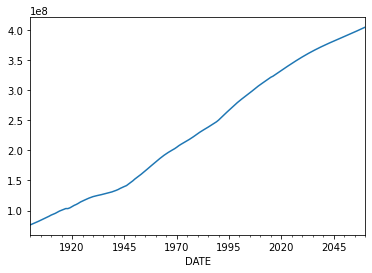

In [86]:
df_to_plot['TOT_POP',999].plot()


<AxesSubplot:xlabel='year', ylabel='value'>

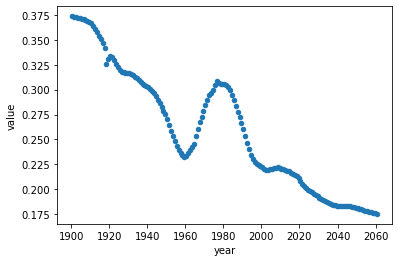

In [87]:
df =youth_fraction.to_frame()

df.reset_index(inplace=True)
df.columns = ['year','value']
df.plot(kind='scatter',x='year',y='value')

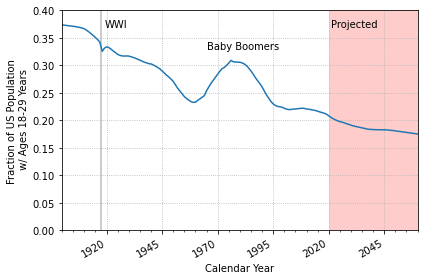

In [88]:
#On to plotting!
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

fig, ax = plt.subplots()
ax = youth_fraction.plot()
ax.set_ylabel('Fraction of US Population\n w/ Ages 18-29 Years')
ax.set_xlabel('Calendar Year')
ax.set_ylim(0,0.4)


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
# format the ticks
#ax.xaxis.set_major_locator(years)
#ax.xaxis.set_major_formatter(years_fmt)
#ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(youth_fraction.index[0], 'Y')
datemax = np.datetime64(youth_fraction.index[120], 'Y') #+ np.timedelta64(1, 'Y') #120 is 2020-07-01
#ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.


#ax.axvline(x=qw.index[120],c='k',ls='--',ymin=0.6,ymax=0.75)
ax.axvspan(youth_fraction.index[120], youth_fraction.index[-1], facecolor='r', alpha=0.2)
ax.text(youth_fraction.index[121], 0.37, 'Projected')

ax.axvspan(pd.Timestamp('April 6, 1917'), pd.Timestamp('November 11, 1918'), facecolor='k', alpha=0.2)
ax.text(pd.Timestamp('November 11, 1919'), 0.37, 'WWI')
ax.grid(True,linestyle=':')

ax.text(pd.Timestamp('1/1/1965'), 0.33, 'Baby Boomers')



# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig('../reports/figures/youth_fraction.png',dpi=300)